## <img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Capstone - Part 2 - Airline Performance Analysis
## Roshan Lulu 
https://roshanlulu.github.io/

### A quick introduction to my project aim and dataset.

The aim of this project is to analyse performance of various airlines. I have an aviation accident database covering incidents from the lasts few decades. All civil and commercial aviation accidents of scheduled and non-scheduled passenger airliners worldwide, which resulted in a fatality.

These are the initial goals I planned to acheive:

- Is there a preferred airline?
- Is there any aircraft that is highly reliable or unreliable?
- Are there flight routes that require extra attention?
- Which was the time period with more accidents?
- Come up with an estimation of what can be considered as a safe flight.

### Are there any risks or assumptions?
 
Accidents are never trivial, but considering the frequency of aviation accidents, a potential risk I foresee is the less number of data points/features to apply the various machine learning models that I have learnt during the data science course. The potential datasets are added to cover this case.

### How did I get the Dataset? What are the Potential Datasets?

- Dataset
- http://www.planecrashinfo.com/database.htm
    - This dataset was in Unstructured format and datapoints were available in different html pages.
    - The challenge here was to scrap the data.
    - A scrapy bot was used to scrap the data and convert it into csv format. (Refer: ../Capstone_Roshan/bots)  
    https://roshanlulu.github.io/data/science,/scrapy/2017/04/28/crawl-and-scrape.html
 

- Potential Datasets:
- https://www.kaggle.com/usdot/flight-delays
    - This dataset has information about the on-time arrival/delay information of domestic flights operated by large air carriers in USA.
    - Why this? It is a good dataset for measuring the airline performance model and applying the machine learning models.

- https://aviation-safety.net/database/
    - Aviation Safety also provides similar information as plane crash info in a different structure
    - Data is in unstructured format, hence needs to be scrapped from the website.
    
### Further Evaluation
- Proposed Methods and Models
    - Machine learning algorithms such as KNN Classifiers etc would be were I would like to go next. In case of a prediction model, I would like to use the regression models.

- Tuning Metrics and Evaluation Approaches
    - I am interested in applying the basic confidence intervals and k-tests for further investigation.

## 1. Load dataset and save to sql database

In [1]:
import pandas as pd
import numpy as np

### Loading the data that I have scraped and saved as a .csv file

In [2]:
crashes = pd.read_csv('../datasets/plane_crash_info.csv')

In [3]:
import sqlite3
sqlite_db = '../database/plane_crash_info.sqlite'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

In [4]:
crashes.to_sql('crashes',             # Name of the table
            con=conn,                    # The handle to the file that is setup
            if_exists='replace',         # Overwrite, append, or fail
            index=False)                 # Add index as column

In [5]:
# close connection
conn.close()

## 2. DATA CLEANING, DATA MUNGING, EDA

In [6]:
# Check the data shape to figure out the number of data samples that are available
print('Shape of data', crashes.shape)

Shape of data (5762, 13)


In [7]:
# Since this is accidents in the airline industry and the data varies over almost a century, 
# it would be good to check what the data tells.
(crashes.head(2))

,Date,Time,Location,operator,Flight,Route,AcType,Reg,CnLn,Aboard,Fatalities,Ground:,Summary
0,"September 17, 1908",17:18,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2 (passengers:1 crew:1),1 (passengers:1 crew:0),0,"During a demonstration flight, a U.S. Army fly..."
1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1 (passengers:0 crew:1),1 (passengers:0 crew:0),0,Eugene Lefebvre was the first pilot to ever be...


In [8]:
# The data seems to have some missing values which are denoted by '?'.
# Replace '?' with null/nan values for easier manipulation later on
crashes.replace("?",np.nan, inplace = True)
crashes.head(2)

,Date,Time,Location,operator,Flight,Route,AcType,Reg,CnLn,Aboard,Fatalities,Ground:,Summary
0,"September 17, 1908",17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2 (passengers:1 crew:1),1 (passengers:1 crew:0),0,"During a demonstration flight, a U.S. Army fly..."
1,"September 07, 1909",NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1 (passengers:0 crew:1),1 (passengers:0 crew:0),0,Eugene Lefebvre was the first pilot to ever be...


In [9]:
# Check out the features in the dataframe
features = crashes.columns
print(features)
# There are 13 feature names

Index(['Date', 'Time', 'Location', 'operator', 'Flight', 'Route', 'AcType',
       'Reg', 'CnLn', 'Aboard', 'Fatalities', 'Ground:', 'Summary'],
      dtype='object')


In [10]:
# Do any feature names require cleaning?
# Ground does not seem to convey the feature information. I would like to rename it.
crashes.rename(columns={'Ground:': 'Ground_Fatalities'}, inplace=True)
crashes.rename(columns={'operator': 'Airline_Operator'}, inplace=True)
crashes.rename(columns={'AcType': 'Aircraft_Type'}, inplace=True)

In [11]:
# Check the null values in the dataset
# Function to check the null counts in a dataframe
def checknullcount(data):
    info = []
    columns = ('Feature', 'Nullcount')
    for col in data.columns:
        nullcount = data[col].isnull().sum()
        info.append([col, nullcount])
    return (pd.DataFrame(columns=columns, data=info).sort_values('Nullcount', ascending = False))

(checknullcount(crashes))
# Out of the 5762 data points that are available, the following assumptions were done for the null count.

,Feature,Nullcount
4,Flight,4428
1,Time,2117
5,Route,1499
8,CnLn,1210
7,Reg,354
12,Summary,232
11,Ground_Fatalities,49
6,Aircraft_Type,24
3,Airline_Operator,21
2,Location,6


In [12]:
import random
# Null counts for Flight are very high = 4428 , I checked flight.unique and it returned 881 unique
# values.  

print('No of unique Flights:', crashes['Flight'].nunique())

# This means that the flights are random numbers, so I can substitute any random number that 
# is not in the set crashes['Flight'].unique()
crashes['Flight'].fillna(random.choice(range(100,4429)), inplace=True)

No of unique Flights: 880


In [13]:
# Date - The date can be split into Day, Month and Year
from datetime import datetime as dt

crashes['Year'] = pd.DatetimeIndex(crashes['Date']).year
crashes['Month'] = pd.DatetimeIndex(crashes['Date']).month
crashes['Day'] = pd.DatetimeIndex(crashes['Date']).day
crashes.drop('Date', axis=1, inplace = True)

In [14]:
# There seem to be a lot of military flights. I want to check if that is the one with the maximum number of nulls
# Check thenumber of data points in military flights
import re

flights_only_military = crashes[crashes['Airline_Operator'].str.contains("Military") == True]
# print('No of military accidents: ', len(flights_only_military)) - 829

flights_wo_military = crashes[crashes['Airline_Operator'].str.contains("Military") == False]
# print('Accidents excluding military flights: ', len(flights_wo_military)) - 4933

# Check nulls after the military flights have been removed
# Check the null values in the dataset
print(checknullcount(flights_wo_military))

# For now I will not drop them. instead create a dummy column which indicates if the type is military or not
crashes['Military'] = [1 if 'Military' in str(row) else 0 for row in crashes['Airline_Operator']]

              Feature  Nullcount
0                Time       1762
4               Route       1066
7                CnLn        831
11            Summary        185
6                 Reg        159
10  Ground_Fatalities         37
5       Aircraft_Type         12
1            Location          6
2    Airline_Operator          0
3              Flight          0
8              Aboard          0
9          Fatalities          0
12               Year          0
13              Month          0
14                Day          0


In [15]:
# Null counts for Time variable is around 2117. I do not want to drop this feature, coz this could be a good variable
# to indicate if the incident occured at day/night. 
# Convert Time to time format
import datetime
import numpy as np

print('Number of unique time values', crashes['Time'].nunique())
# Impute null values by choosing from non null values within the column
crashes['Time'].fillna(random.choice(crashes[crashes['Time'] != np.nan]['Time']), inplace=True)
# Some values in time have alphabets. Remove any non digit charachter. 
# Note that the time format has now changed from HH:MM to HHMM
crashes['Time'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

# When i checked the cleaned time data in HHMM format, There is one value thatis out of range i.e 11420.
# This can be changed manually
crashes['Time'][crashes['Time']==11420] = 1420


Number of unique time values 1325


/Users/roshanlulu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
# Added a new column
crashes['Time_AM'] = [1 if (float(time) < 1200) else 0 for time in crashes['Time']]
crashes.head(2)

,Time,Location,Airline_Operator,Flight,Route,Aircraft_Type,Reg,CnLn,Aboard,Fatalities,Ground_Fatalities,Summary,Year,Month,Day,Military,Time_AM
0,1718,"Fort Myer, Virginia",Military - U.S. Army,4234,Demonstration,Wright Flyer III,NaN,1,2 (passengers:1 crew:1),1 (passengers:1 crew:0),0,"During a demonstration flight, a U.S. Army fly...",1908,9,17,1,0
1,0540,"Juvisy-sur-Orge, France",NaN,4234,Air show,Wright Byplane,SC1,NaN,1 (passengers:0 crew:1),1 (passengers:0 crew:0),0,Eugene Lefebvre was the first pilot to ever be...,1909,9,7,0,1


In [17]:
# Checking the Route data
print((crashes.Route.nunique()))
# There are 1499 Null values in Route. The Route is unique for each incident

(crashes.Route.value_counts().sort_values(ascending=False))

# From the below information, these are the types of routes available
# Training - 95, Sightseeing - 40, Test flights - 28, Demonstration - 3, Positioning - 3, Parachuting data - 3, Skydiving - 3
# The others are Commercial flights from 1 destination to another.
# not_commercial = ['Training', 'Sightseeing', 'Test Flight', 'Skydiving', 'Parachuting', 'Positioning', 'Demonstration']

# There is Test and Test Flight. COmbining the two into 1 category
crashes['Route'][crashes['Route']=='Test'] = 'Test flight'
crashes['Route'].fillna('Unknown-Unknown', inplace = True)
# len(pd.Series(not_commercial)) = 255
# There seem to be 255 Not Commercial flights 

3840


/Users/roshanlulu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
not_commercial = [route for route in crashes.Route if '-' not in route]
# Obtained the not commercial flights from  ==> pd.Series(not_commercial).unique()
not_commercial = ['Demonstration', 'Air show', 'Test flight',
       'Delivery flight', 'Sightseeing', 'Testing',
       'Sightseeing over Rotterdam', 'Bremerton', 'Demonistration',
       'Training', 'Instructional Flight',
       'Bombing run',
       'Training flight', 'Test Flight', 'Rejeka and Zagreb',
       'Radio surveillance mission', 'Scrampton RAF Station, England',
       'Military exercise', 'Unalakleet and Nome', 'Reconnaissance',
       'Training exercise', 'Maintenance flight', 'Otis AFB',
       'Service mission', 'Exercises', 'Exercise', 'Demo flight', 'Survey',
       'Military exercises', 'Local tour', 'Positioning', 'None',
       'Movie set', 'Airshow',
       'Washington D.C. Baltimore, MD', 'Parachuting', 'Traffic reporting',
       'Local Flight', 'Observation flight out of Cape Schmidt',
       'Grand Canyon National Park', 'Palambang and Jakarta',
       'Local sightseeing', 'Local',
       'Selway Lodge, ID  Salmon, ID', 'Air Show', 'Search mission',
       'Sighteeing', 'Sky Diving', 'Sight seeing', 'Skydiving',
       'Decatur Island, WAAnacortez, WA', 'Winnipeg Manitoba',
       'Ferrying troops', 'Khost to Kabul', 'Training/Aranchi', 'Shuttle',
       'Lilongwe to Rumchi', 'Transporting troops', 'Medical flight',
       'Ferrying fire fighters', 'Medical evacuation flight',
       'Militiary training', 'Patrol', 'Practice maneuvers', 'Air race',
       'Demonstration flight', 'From Gauchar airstrip', 'News reporting']

# Add a new column that indicates 'Commercial'
crashes['Commercial'] = [0 if route in not_commercial else 1 for route in crashes.Route]

In [19]:
# CnLn does not seem to be a column I will use. So I will be filling null values to 0
print(crashes.CnLn.nunique())
crashes['CnLn'].fillna(0, inplace = True)

4119


In [20]:
# Registration does not seem to be a column that is crucial for the crash data at the moment. 
# So I will be filling null values to 0
print(crashes.CnLn.nunique())
crashes['Reg'].fillna(0, inplace = True)

4120


In [21]:
# Summary would be a required column. Later on in the project it would be useful to get insights about the accident
# by looking for words that relate to the cause of the accident. 
# Eg: piloterror, mechanical fault, engine failure, weather, mountain, landing, takeoff etc
# To remove the null values, I will fill it with information not provided.
crashes['Summary'].fillna('Information Not provided in the dataset', inplace = True)

In [22]:
# Aboard, Fatalities and Ground_Fatalities - Clean these 3 columns
import re

# Clean data from the column Aboard. There are no null values, but the data contains multiple information
aboard = [re.findall(r'\d+', aboard) for aboard in crashes.Aboard]
aboard_df = pd.DataFrame(aboard, columns = ['TotalAboard', 'PassAboard', 'CrewAboard'])
aboard_df.fillna(0, inplace = True)
aboard_df.head()

,TotalAboard,PassAboard,CrewAboard
0,2,1,1
1,1,0,1
2,5,0,5
3,1,0,1
4,41,0,0


In [23]:
# Clean data from the column fatalities. There are no null values, but the data contains multiple information
fatalities = [re.findall(r'\d+', fatal) for fatal in crashes.Fatalities]
fatalities_df = pd.DataFrame(fatalities, columns = ['TotalFatal', 'PassFatal', 'CrewFatal'])
fatalities_df.fillna(0, inplace = True)
fatalities_df.head()

,TotalFatal,PassFatal,CrewFatal
0,1,1,0
1,1,0,0
2,5,0,5
3,1,0,1
4,21,0,0


In [24]:
# Concatenate the aboard and fatalities dataframe to the crashes dataframe
crashes = pd.concat([crashes, aboard_df, fatalities_df], axis = 1)
# Delete the redundant columns in crashes dataframe
crashes.drop(['Aboard', 'Fatalities'], inplace = True, axis = 1)
crashes.columns

Index(['Time', 'Location', 'Airline_Operator', 'Flight', 'Route',
       'Aircraft_Type', 'Reg', 'CnLn', 'Ground_Fatalities', 'Summary', 'Year',
       'Month', 'Day', 'Military', 'Time_AM', 'Commercial', 'TotalAboard',
       'PassAboard', 'CrewAboard', 'TotalFatal', 'PassFatal', 'CrewFatal'],
      dtype='object')

In [25]:
# ground = [re.findall(r'\d+', fatal) for fatal in crashes['Ground:']]
# Change null values in ground to 0
crashes['Ground_Fatalities'].fillna('0', inplace = True)
crashes['Ground_Fatalities'].value_counts()
# Look at the dataframe after features have been updated/deleted
crashes.head(2)

,Time,Location,Airline_Operator,Flight,Route,Aircraft_Type,Reg,CnLn,Ground_Fatalities,Summary,...,Day,Military,Time_AM,Commercial,TotalAboard,PassAboard,CrewAboard,TotalFatal,PassFatal,CrewFatal
0,1718,"Fort Myer, Virginia",Military - U.S. Army,4234,Demonstration,Wright Flyer III,0,1,0,"During a demonstration flight, a U.S. Army fly...",...,17,1,0,0,2,1,1,1,1,0
1,0540,"Juvisy-sur-Orge, France",NaN,4234,Air show,Wright Byplane,SC1,0,0,Eugene Lefebvre was the first pilot to ever be...,...,7,0,1,0,1,0,1,1,0,0


In [26]:
# Aircraft_Type
# len(crashes.Aircraft_Type.unique())=2720, null values = 24
# After investigating the null data from the Aircraft Type, 
# I understand it should be ok to drop it, 
# but instead I could also just keep it as Unknown as the other information might be useful

print('Unique aircraft types', crashes.Aircraft_Type.nunique())
print(crashes.Aircraft_Type.value_counts())
crashes['Aircraft_Type'].fillna('Unknown', inplace = True)

Unique aircraft types 2719
Douglas DC-3                                340
de Havilland Canada DHC-6 Twin Otter 300     86
Douglas C-47A                                75
Douglas C-47                                 67
Douglas DC-4                                 41
Yakovlev YAK-40                              37
Antonov AN-26                                35
Junkers JU-52/3m                             32
Douglas C-47B                                29
Douglas DC-6B                                28
De Havilland DH-4                            27
Cessna 208B Grand Caravan                    26
Douglas DC-6                                 21
Curtiss C-46A                                21
Breguet 14                                   21
Douglas C-47-DL                              19
McDonnell Douglas DC-9-32                    19
Antonov AN-24                                19
Curtiss C-46                                 19
Antonov AN-12                                18
Embraer 110P1

In [27]:
# Airline_Operator
# len(crashes.Airline_Operator.unique())=2796, null values = 21
# After investigating the null data from the Aircraft Type, 
# I understand it should be ok to drop it considering it is a small no, 
# but instead I prefer to keep it as Unknown as the other information might be useful
crashes['Airline_Operator'].fillna('Unknown', inplace = True)
(crashes.Airline_Operator.nunique())

2796

In [28]:
# Location - It can be used to get the latitudes and longitudes using the google maps api
#             - Location is currently in City, Country format. It can be split into 2 columns

# The location parameters range from 1 value to 4 values when split.
# Split the location feature to Country, State, Town and City
# loc = [location.split(',')[::-1] for location in crashes.Location]
# loc = pd.DataFrame(loc, columns = ['Country', 'State', 'City', 'Town'])
# # Check for null values in country
# crashes = pd.concat([crashes, loc], axis = 1)
# crashes.head()
crash_location = [str(row).split(',')[::-1][0] for row in crashes.Location]
crash_location = pd.DataFrame(crash_location, columns = ['Country'])
# crash_location.drop(['City', 'Town'], inplace = True, axis = 1)
crashes = pd.concat([crashes, crash_location], axis = 1)
crashes.head(2)

,Time,Location,Airline_Operator,Flight,Route,Aircraft_Type,Reg,CnLn,Ground_Fatalities,Summary,...,Military,Time_AM,Commercial,TotalAboard,PassAboard,CrewAboard,TotalFatal,PassFatal,CrewFatal,Country
0,1718,"Fort Myer, Virginia",Military - U.S. Army,4234,Demonstration,Wright Flyer III,0,1,0,"During a demonstration flight, a U.S. Army fly...",...,1,0,0,2,1,1,1,1,0,Virginia
1,0540,"Juvisy-sur-Orge, France",Unknown,4234,Air show,Wright Byplane,SC1,0,0,Eugene Lefebvre was the first pilot to ever be...,...,0,1,0,1,0,1,1,0,0,France


In [29]:
crashes['Country'].isnull().sum()

0

In [30]:
# There are quite a few spelling mistakes in the country names. Trying to clean it.
afNames = ['Afghanstan'] #Afghanistan
anNames = ['off Angola'] #Angola
ausNames = ['Qld. Australia','Queensland  Australia','Tasmania','off Australia'] #Australia
argNames = ['Aregntina'] #Argentina
azNames = ['Azores (Portugal)'] #Azores
baNames = ['Baangladesh'] #Bangladesh
bahNames = ['Great Inagua'] #Bahamas
berNames = ['off Bermuda'] #Bermuda
bolNames = ['Boliva','BO'] #Bolivia
bhNames = ['Bosnia-Herzegovina'] #Bosnia Herzegovina
bulNames = ['Bugaria','Bulgeria'] #Bulgaria
canNames = ['British Columbia', 'British Columbia Canada','Canada2',
            'Saskatchewan','Yukon Territory'] #Canada
camNames = ['Cameroons','French Cameroons'] #Cameroon
caNames = ['Cape Verde Islands'] #Cape Verde
chNames = ['Chili'] #Chile
coNames = ['Comoro Islands', 'Comoros Islands'] #Comoros
djNames = ['Djbouti','Republiof Djibouti'] #Djibouti
domNames = ['Domincan Republic', 'Dominica'] #Dominican Republic
drcNames = ['Belgian Congo','Belgian Congo (Zaire)','Belgium Congo'
           'DR Congo','DemocratiRepubliCogo','DemocratiRepubliCongo',
            'DemocratiRepubliof Congo','DemoctratiRepubliCongo','Zaire',
           'Zaïre'] #Democratic Republic of Congo
faNames = ['French Equitorial Africa'] #French Equatorial Africa
gerNames = ['East Germany','West Germany'] #Germany
grNames = ['Crete'] #Greece
haNames = ['Hati'] #Haiti
hunNames = ['Hunary'] #Hungary
inNames = ['Indian'] #India
indNames = ['Inodnesia','Netherlands Indies'] #Indonesia
jamNames = ['Jamacia'] #Jamaica
malNames = ['Malaya'] #Malaysia
manNames = ['Manmar'] #Myanmar
marNames = ['Mauretania'] #Mauritania
morNames = ['Morrocco','Morroco'] #Morocco
nedNames = ['Amsterdam','The Netherlands'] #Netherlands
niNames = ['Niger'] #Nigeria
philNames = ['Philipines','Philippine Sea', 'Phillipines',
            'off the Philippine island of Elalat'] #Philippines
romNames = ['Romainia'] #Romania
rusNames = ['Russian','Soviet Union','USSR'] #Russia
saNames = ['Saint Lucia Island'] #Saint Lucia
samNames = ['Western Samoa'] #Samoa
siNames = ['Sierre Leone'] #Sierra Leone
soNames = ['South Africa (Namibia)'] #South Africa
surNames = ['Suriname'] #Surinam
uaeNames = ['United Arab Emirates', 'UAE'] #UAE
usNames = ['Virginia','New Jersey','Ohio','Pennsylvania', 'Maryland', 'Indiana', 'Iowa',
          'Illinois','Wyoming', 'Minnisota', 'Wisconsin', 'Nevada', 'NY','California',
          'WY','New York','Oregon', 'Idaho', 'Connecticut','Nebraska', 'Minnesota', 'Kansas',
          'Texas', 'Tennessee', 'West Virginia', 'New Mexico', 'Washington', 'Massachusetts',
          'Utah', 'Ilinois','Florida', 'Michigan', 'Arkansas','Colorado', 'Georgia''Missouri',
          'Montana', 'Mississippi','Alaska','Jersey', 'Cailifornia', 'Oklahoma','North Carolina',
          'Kentucky','Delaware','D.C.','Arazona','Arizona','South Dekota','New Hampshire','Hawaii',
          'Washingon','Massachusett','Washington DC','Tennesee','Deleware','Louisiana',
          'Massachutes', 'Louisana', 'New York (Idlewild)','Oklohoma','North Dakota','Rhode Island',
          'Maine','Alakska','Wisconson','Calilfornia','Virginia','Virginia.','CA','Vermont',
          'HI','AK','IN','GA','Coloado','Airzona','Alabama','Alaksa' 
          ]
ukNames = ['England', 'UK','Wales','110 miles West of Ireland', 'Scotland'] #United Kingdom
uvNames = ['US Virgin Islands','Virgin Islands','U.S. Virgin Islands'] #U.S. Virgin Islands
vietNames = ['South Vietnam']
wkNames = ['325 miles east of Wake Island']#Wake Island
yuNames = ['Yugosalvia'] #Yugoslavia
zimNames = ['Rhodesia', 'Rhodesia (Zimbabwe)'] #Zimbabwe

clnames = []
for country in crashes['Country'].values:
    if country in afNames:
        clnames.append('Afghanistan')
    elif country in anNames:
        clnames.append('Angola')
    elif country in ausNames:
        clnames.append('Australia')
    elif country in argNames:
        clnames.append('Argentina')
    elif country in azNames:
        clnames.append('Azores')
    elif country in baNames:
        clnames.append('Bangladesh')
    elif country in bahNames:
        clnames.append('Bahamas')
    elif country in berNames:
        clnames.append('Bermuda')
    elif country in bolNames:
        clnames.append('Bolivia')
    elif country in bhNames:
        clnames.append('Bosnia Herzegovina')
    elif country in bulNames:
        clnames.append('Bulgaria')
    elif country in canNames:
        clnames.append('Canada')
    elif country in camNames:
        clnames.append('Cameroon')
    elif country in caNames:
        clnames.append('Cape Verde')
    elif country in chNames:
        clnames.append('Chile')
    elif country in coNames:
        clnames.append('Comoros')
    elif country in djNames:
        clnames.append('Djibouti')
    elif country in domNames:
        clnames.append('Dominican Republic')
    elif country in drcNames:
        clnames.append('Democratic Republic of Congo')
    elif country in faNames:
        clnames.append('French Equatorial Africa')
    elif country in gerNames:
        clnames.append('Germany')
    elif country in grNames:
        clnames.append('Greece')
    elif country in haNames:
        clnames.append('Haiti')
    elif country in hunNames:
        clnames.append('Hungary')
    elif country in inNames:
        clnames.append('India')
    elif country in jamNames:
        clnames.append('Jamaica')
    elif country in malNames:
        clnames.append('Malaysia')
    elif country in manNames:
        clnames.append('Myanmar')
    elif country in marNames:
        clnames.append('Mauritania')
    elif country in morNames:
        clnames.append('Morocco')
    elif country in nedNames:
        clnames.append('Netherlands')
    elif country in niNames:
        clnames.append('Nigeria')
    elif country in philNames:
        clnames.append('Philippines')
    elif country in romNames:
        clnames.append('Romania')
    elif country in rusNames:
        clnames.append('Russia')
    elif country in saNames:
        clnames.append('Saint Lucia')
    elif country in samNames:
        clnames.append('Samoa')
    elif country in siNames:
        clnames.append('Sierra Leone')
    elif country in soNames:
        clnames.append('South Africa')
    elif country in surNames:
        clnames.append('Surinam')
    elif country in uaeNames:
        clnames.append('UAE')
    elif country in ukNames:
        clnames.append('United Kingdom')
    elif country in usNames:
        clnames.append('United States of America')
    elif country in uvNames:
        clnames.append('U.S. Virgin Islands')
    elif country in vietNames:
        clnames.append('Vietnam')
    elif country in wkNames:
        clnames.append('Wake Island')
    elif country in yuNames:
        clnames.append('Yugoslavia')
    elif country in zimNames:
        clnames.append('Zimbabwe')
    else:
        clnames.append(country)
        
crashes['Country'] = clnames

# I choose not to encode the country names as later data readins for long lat will give more precise locations, 
# However, will keep these for possible grouping after the EDA
# The names will be ignored for the rest of this EDA

In [31]:
# Location - There are 6 null values. Checking the data, the route and Location are Null for these 6 values
# I would prefer to drop them
crashes[crashes['Location'].isnull()]
crashes['Location'].dropna(inplace = True, axis = 0)

In [32]:
# Rearrange columns 
order_columns = ['Year', 'Month', 'Day', 'Time', 'Time_AM',
                 'Location','Country', 'Route',
                 'Airline_Operator', 'Flight', 'Aircraft_Type', 'Commercial','Military',
                 'Reg', 'CnLn', 'Ground_Fatalities',
                 'TotalAboard', 'PassAboard', 'CrewAboard', 'TotalFatal', 'PassFatal', 'CrewFatal', 'Summary']

In [33]:
# Reorder the dataframe wrt new columns
if len(crashes.columns) == len(order_columns):
    crashes = crashes[order_columns]
else:
    assert len(crashes.columns) == len(order_columns)

In [34]:
# Rechecking the null count after cleaning the data.
checknullcount(crashes)
# Successfully cleaned the null values!

,Feature,Nullcount
5,Location,6
0,Year,0
12,Military,0
21,CrewFatal,0
20,PassFatal,0
19,TotalFatal,0
18,CrewAboard,0
17,PassAboard,0
16,TotalAboard,0
15,Ground_Fatalities,0


In [35]:
# Checking and updating datatype of the following columns to int

# Ground_Fatalities    object
# TotalAboard          object
# PassAboard           object
# CrewAboard           object
# TotalFatal           object
# PassFatal            object
# CrewFatal            object
crashes['Ground_Fatalities'] = crashes['Ground_Fatalities'].astype(int)
crashes['TotalAboard'] = crashes['TotalAboard'].astype(int)
crashes['PassAboard'] = crashes['PassAboard'].astype(int)
crashes['CrewAboard'] = crashes['CrewAboard'].astype(int)
crashes['TotalFatal'] = crashes['TotalFatal'].astype(int)
crashes['PassFatal'] = crashes['PassFatal'].astype(int)
crashes['CrewFatal'] = crashes['CrewFatal'].astype(int)
crashes.dtypes

Year                  int32
Month                 int32
Day                   int32
Time                 object
Time_AM               int64
Location             object
Country              object
Route                object
Airline_Operator     object
Flight               object
Aircraft_Type        object
Commercial            int64
Military              int64
Reg                  object
CnLn                 object
Ground_Fatalities     int64
TotalAboard           int64
PassAboard            int64
CrewAboard            int64
TotalFatal            int64
PassFatal             int64
CrewFatal             int64
Summary              object
dtype: object

In [36]:
crashes.describe()
# The numerical features in the data description does not help much abpout studying the data since most of the features are text based.
# Although, it is interesting toknow that the average total fatalities has been around 20 for the 5762 crashes that have occured.

,Year,Month,Day,Time_AM,Commercial,Military,Ground_Fatalities,TotalAboard,PassAboard,CrewAboard,TotalFatal,PassFatal,CrewFatal
count,5762.000000,5762.000000,5762.000000,5762.000000,5762.000000,5762.000000,5762.000000,5762.000000,5762.000000,5762.000000,5762.000000,5762.000000,5762.000000
mean,1972.627039,6.691774,15.761194,0.633808,0.956786,0.143874,1.516487,27.314301,21.674072,3.748872,19.890316,15.290698,3.024124
std,23.531774,3.550772,8.806739,0.481805,0.203357,0.350992,51.527659,42.768069,40.717395,3.514535,32.859214,31.266075,3.131711
min,1908.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1954.000000,3.000000,8.000000,0.000000,1.000000,0.000000,0.000000,5.000000,0.000000,1.000000,3.000000,0.000000,1.000000
50%,1973.000000,7.000000,16.000000,1.000000,1.000000,0.000000,0.000000,13.000000,7.000000,3.000000,9.000000,4.000000,2.000000
75%,1992.000000,10.000000,23.000000,1.000000,1.000000,0.000000,0.000000,30.000000,23.000000,5.000000,22.000000,16.000000,4.000000
max,2017.000000,12.000000,31.000000,1.000000,1.000000,1.000000,2750.000000,644.000000,614.000000,61.000000,583.000000,560.000000,46.000000


## 3. DATA DICTIONARY

In [37]:
# I have modified a few columns from the original dataframe. Below is a description of the cleaned dataset.


data_dict = {'Year': {
       'type':crashes.Year.dtype,
       'description':'Year of Accident'
   },
 'Month': {
       'type':crashes.Month.dtype,
       'description':'Month of Accident'
   },
 'Day': {
       'type':crashes.Day.dtype,
       'description':'Day of Accident'
   }, 
 'Time': {
       'type':crashes.Time.dtype,
       'description':'Time of Accident'
   },
 'Time_AM': {
       'type':crashes.Time_AM.dtype,
       'description':'AM/PM Information from the time'
   },
 'Location': {
       'type':crashes.Location.dtype,
       'description':'Location of Accident'
   },
 'Country': {
       'type':crashes.Country.dtype,
       'description':'Country'
   },
 'Route': {
       'type':crashes.Route.dtype,
       'description':'Complete or partial route flown prior to the accidentoute'
   },
 'Airline_Operator': {
       'type':crashes.Airline_Operator.dtype,
       'description':'Airline or operator of the aircraft'
   },
 'Flight': {
       'type':crashes.Flight.dtype,
       'description':'Flight number assigned by the aircraft operator'
   },
 'Aircraft_Type': {
       'type':crashes.Aircraft_Type.dtype,
       'description':'Aircraft_Type'
   },
 'Commercial': {
       'type':crashes.Commercial.dtype,
       'description':'Commercial'
   },
 'Military': {
       'type':crashes.Military.dtype,
       'description':'Military',
   },
 'Reg': {
       'type':crashes.Reg.dtype,
       'description': 'ICAO registration of the aircraft'
   },
 'CnLn': {
       'type':crashes.CnLn.dtype,
       'description':'Construction or serial number / Line or fuselage number'
   }, 
 'Ground_Fatalities': {
       'type':crashes.Ground_Fatalities.dtype,
       'description':'Total killed on the ground'
   },
 'TotalAboard': {
       'type':crashes.TotalAboard.dtype,
       'description': 'Total aboard (passengers / crew)'
   }, 
 'PassAboard': {
       'type':crashes.PassAboard.dtype,
       'description':'Total Passengers Aboard'
   }, 
 'CrewAboard': {
       'type':crashes.CrewAboard.dtype,
       'description':'Total Crew Aboard'
   }, 
 'TotalFatal': {
       'type':crashes.TotalFatal.dtype,
       'description':'Total Fatalities (passengers / crew)'
   }, 
 'PassFatal': {
       'type':crashes.PassFatal.dtype,
       'description':'Total Fatalities - Passengers'
   }, 
 'CrewFatal': {
       'type':crashes.CrewFatal.dtype,
       'description': 'Total Fatalities - Crew'
   }, 
 'Summary': {
       'type':crashes.Summary.dtype,
       'description':'Location of Accident'
   },
   'dataset_shape':crashes.shape,
   'Database Source': 'www.planecrashinfo.com'
}

(data_dict)

{'Aircraft_Type': {'description': 'Aircraft_Type', 'type': dtype('O')},
 'Airline_Operator': {'description': 'Airline or operator of the aircraft',
  'type': dtype('O')},
 'CnLn': {'description': 'Construction or serial number / Line or fuselage number',
  'type': dtype('O')},
 'Commercial': {'description': 'Commercial', 'type': dtype('int64')},
 'Country': {'description': 'Country', 'type': dtype('O')},
 'CrewAboard': {'description': 'Total Crew Aboard', 'type': dtype('int64')},
 'CrewFatal': {'description': 'Total Fatalities - Crew',
  'type': dtype('int64')},
 'Database Source': 'www.planecrashinfo.com',
 'Day': {'description': 'Day of Accident', 'type': dtype('int32')},
 'Flight': {'description': 'Flight number assigned by the aircraft operator',
  'type': dtype('O')},
 'Ground_Fatalities': {'description': 'Total killed on the ground',
  'type': dtype('int64')},
 'Location': {'description': 'Location of Accident', 'type': dtype('O')},
 'Military': {'description': 'Military', 'type'

## 4. STUDYING THE DATA WITH PLOTS

In [38]:
# Plotting a histogram based on time of accident/incident
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# With the cleaned dataset 
# It is now time to see some insights from the aviation accidents during the time period 1908  - Current

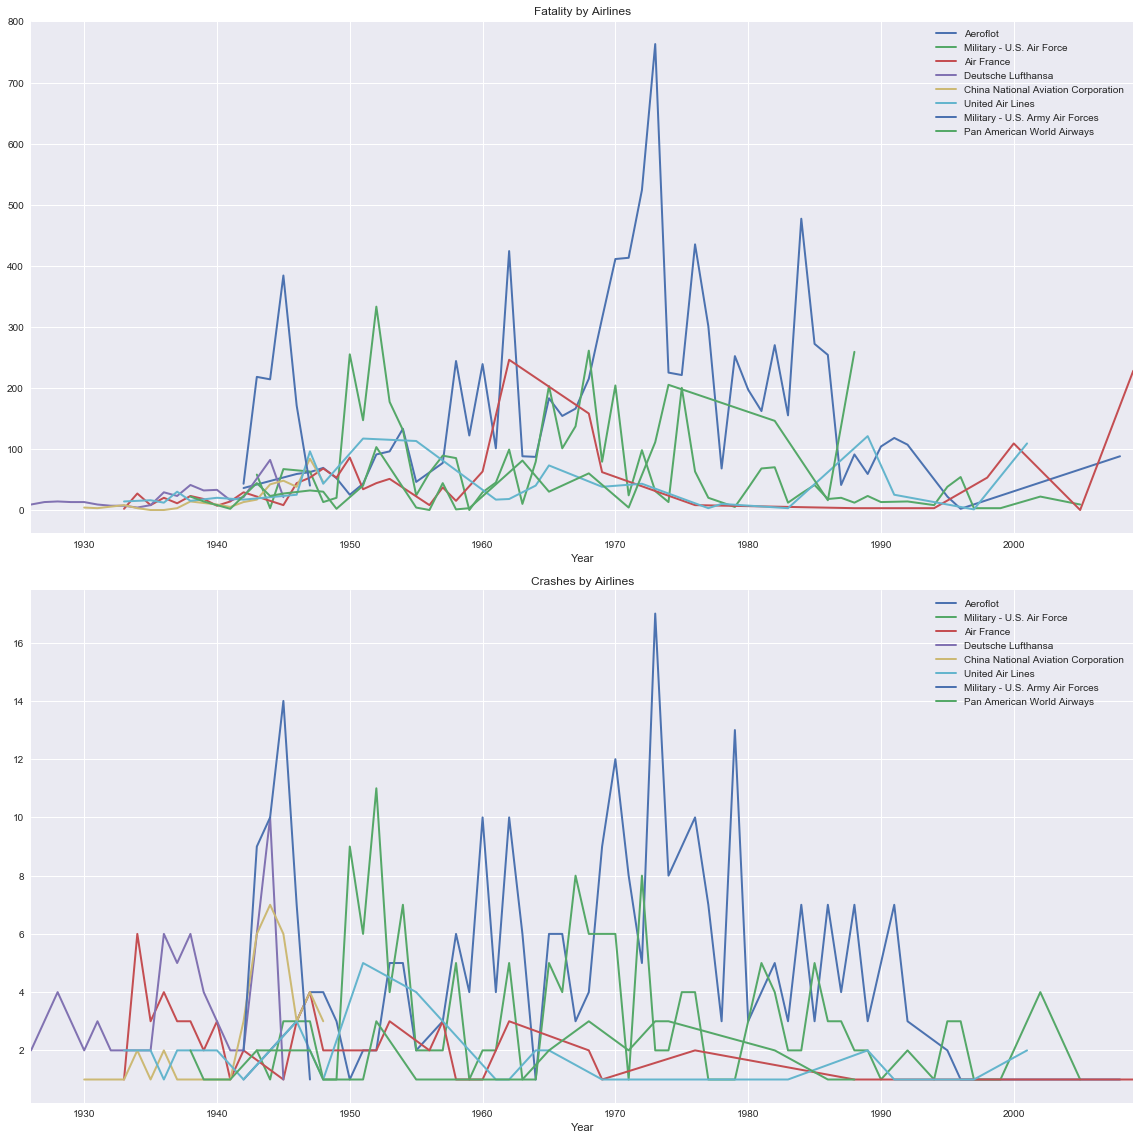

In [40]:
# With my data, pair plots may not be a good idea as the numerical features are quite less in the dataset
# So I am thinking of checking trends of features over time
# I am interested in analysing the trends of the airlines with maximum no of crashes and fatalities from the past
# 

crashes_airline = crashes
crashes_airline = crashes_airline.groupby('Airline_Operator').size().sort_values(ascending = False).head(8)

# These are the 8 airlines that are trending for wrong reasons!
top_airlines = crashes_airline.index

crashes_by_airline = crashes[['Airline_Operator','Year','TotalFatal']].groupby(['Airline_Operator','Year']).agg(['sum','count'])
airlines = crashes_by_airline['TotalFatal'].reset_index()

# Set the plot and subplot
fig,axtrend = plt.subplots(2,1, figsize = (16,16))
# Plot the line for all the top airlines
for al in top_airlines:
    airlines[airlines['Airline_Operator']==al].plot(x='Year',y='sum',ax=axtrend[0],grid=True,linewidth=2)
    airlines[airlines['Airline_Operator']==al].plot(x='Year',y='count',ax=axtrend[1],grid=True,linewidth=2)

# Set the graph Titles
axtrend[0].set_title('Fatality by Airlines')
axtrend[1].set_title('Crashes by Airlines')
# Set the legend labels
linesF, labelsF = axtrend[0].get_legend_handles_labels()
linesA, labelsA = axtrend[1].get_legend_handles_labels()
axtrend[0].legend(linesF,top_airlines)
axtrend[1].legend(linesA,top_airlines)
plt.tight_layout()
plt.show()

# Infer: Looking at the trends of airlines from 1908 to 2017
# Graph1 - fatality by airlines : The no of fatalities are definitely reducing as the timeline moves towards the 20th century
# Plot 2 - crashes by airlines: The number of crashes have obviously reduces after 1980s.
# Airline operators definitely seem to have taken better safety measures and checks

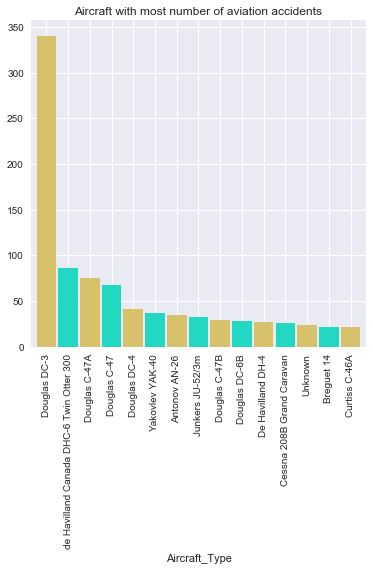

In [41]:
my_colors = pd.tools.plotting._get_standard_colors(2, color_type='random')
plt.subplots(figsize=(6,6))

# Plotting Aircrafts sorted by decreasing number of crashes over time period 1908 till now
crashes_aircraft = crashes
crashes_aircraft = crashes_aircraft.groupby('Aircraft_Type').size().sort_values(ascending = False).head(15)
# Plotting No of crashes on the countries
crashes_aircraft.plot(kind="bar", color=my_colors, width=0.9, title='Aircraft with most number of aviation accidents')
plt.show()

# plt.subplots(figsize=(6,6))
# crashes_aircraft = crashes
# # Bottom 15 Countries sorted by decreasing number of crashes
# crashes_aircraft = crashes_aircraft.groupby('Aircraft_Type').size().sort_values(ascending = False).tail(15)
# # print(crashes_airline)
# # Plotting No of crashes on the countries
# crashes_aircraft.plot(kind="bar", color="g", width=0.75, title='Aircraft with least number of aviation accidents')
# plt.show()

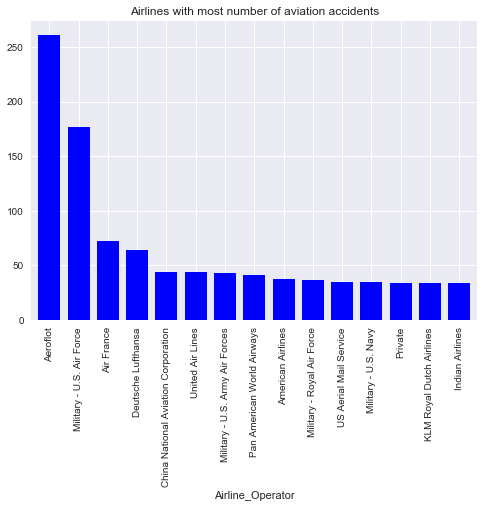

In [42]:
# Airlines sorted by decreasing number of crashes ( Displayed  top 15)
crashes_airline = crashes
crashes_airline = crashes_airline.groupby('Airline_Operator').size().sort_values(ascending = False).head(15)
# Plotting No of crashes on the countries
crashes_airline.plot(kind="bar", color="b", width=0.75, title='Airlines with most number of aviation accidents')
plt.show()
# print(crashes_airline)

# crashes_airline = crashes
# # Bottom 15 Countries sorted by decreasing number of crashes
# crashes_airline = crashes_airline.groupby('Airline_Operator').size().sort_values(ascending = False).tail(15)
# # print(crashes_airline)
# # Plotting No of crashes on the countries
# crashes_airline.plot(kind="bar", color="g", width=0.75, title='Airlines with least number of aviation accidents')
# plt.show()

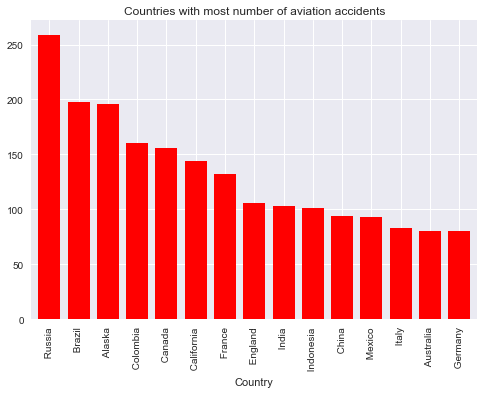

Country
 Russia        259
 Brazil        198
 Alaska        196
 Colombia      160
 Canada        156
 California    144
 France        132
 England       106
 India         103
 Indonesia     101
 China          94
 Mexico         93
 Italy          83
 Australia      80
 Germany        80
dtype: int64

In [43]:
# Top 15 Countries sorted by decreasing number of crashes
crashes_country = crashes
crashes_country = crashes_country.groupby('Country').size().sort_values(ascending = False).head(15)
# Plotting No of crashes on the countries
crashes_country.plot(kind="bar", color="r", width=0.75, title='Countries with most number of aviation accidents')
plt.show()
crashes_country

# Russia is the country with the most number of accidents

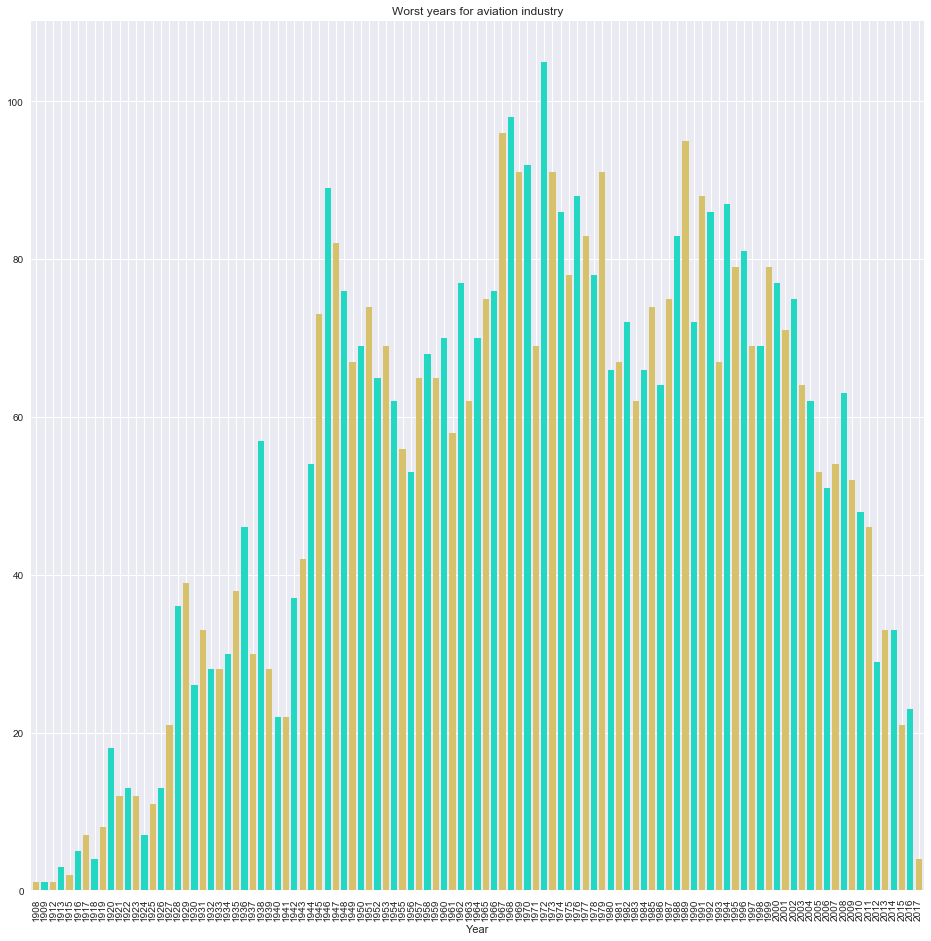

In [44]:
# Worst year in aviation industry
# Top 15 Countries sorted by decreasing number of crashes
my_colors = pd.tools.plotting._get_standard_colors(2, color_type='random')
plt.subplots(figsize=(16,16))
crashes_year = crashes
crashes_year = crashes_year.groupby('Year').size()
# Plotting No of crashes on the countries
crashes_year.plot(kind="bar", color=my_colors, width=0.75, title='Worst years for aviation industry')
plt.show()
# crashes_year

# 1972 is the year witht he most number of accidents

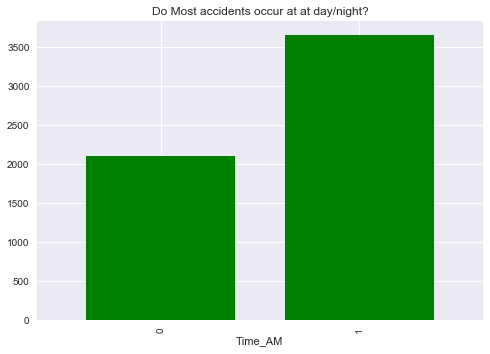

In [45]:
# Do Most accidents occur at at day/night?
crash_day = crashes.groupby('Time_AM').size()
crash_day.plot(kind="bar", color="g", width=0.75, title='Do Most accidents occur at at day/night?')
plt.show()

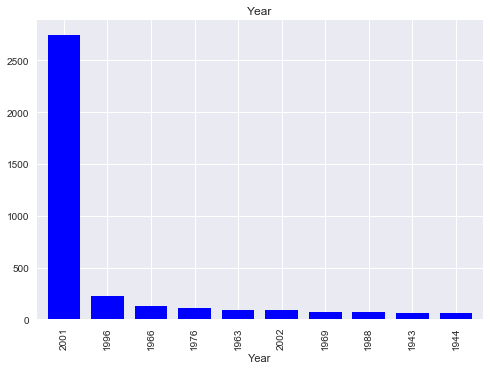

In [46]:
crashes_groundfat = crashes[['Year', 'Ground_Fatalities']]
crashes_groundfat = crashes_groundfat.groupby('Year')['Ground_Fatalities'].max().sort_values(ascending=False)
crashes_groundfat
crashes_groundfat.head(10).plot(kind="bar", color="b", width=0.75, title='Year')
plt.show()

# crashes.sort_values('Ground_Fatalities', ascending = False)

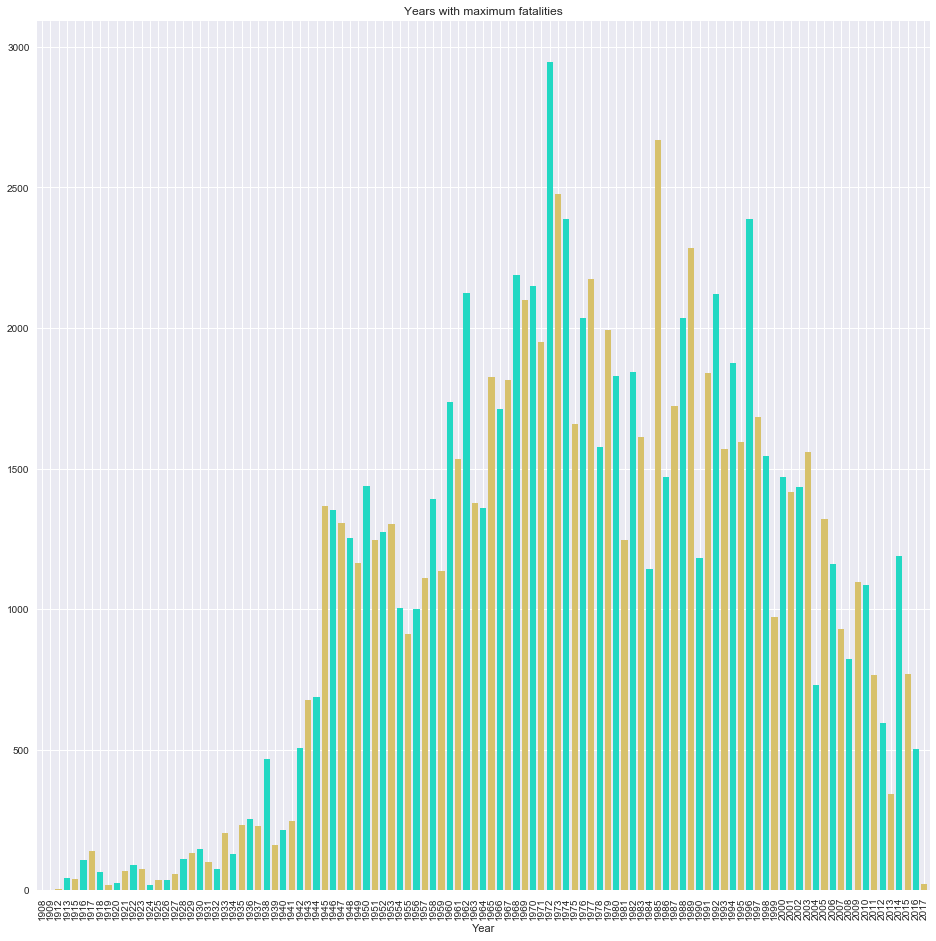

In [47]:
my_colors = pd.tools.plotting._get_standard_colors(2, color_type='random')
plt.subplots(figsize=(16,16))
crashes_fatalities = crashes[['Year', 'TotalFatal']]
crashes_fatalities = crashes_fatalities.groupby('Year')['TotalFatal'].sum()
crashes_fatalities.plot(kind="bar", color=my_colors, width=0.75, title='Years with maximum fatalities')
plt.show()
# 1972 is the year with maximum fatalities. 1972 was definitely the worst year for aviation industry

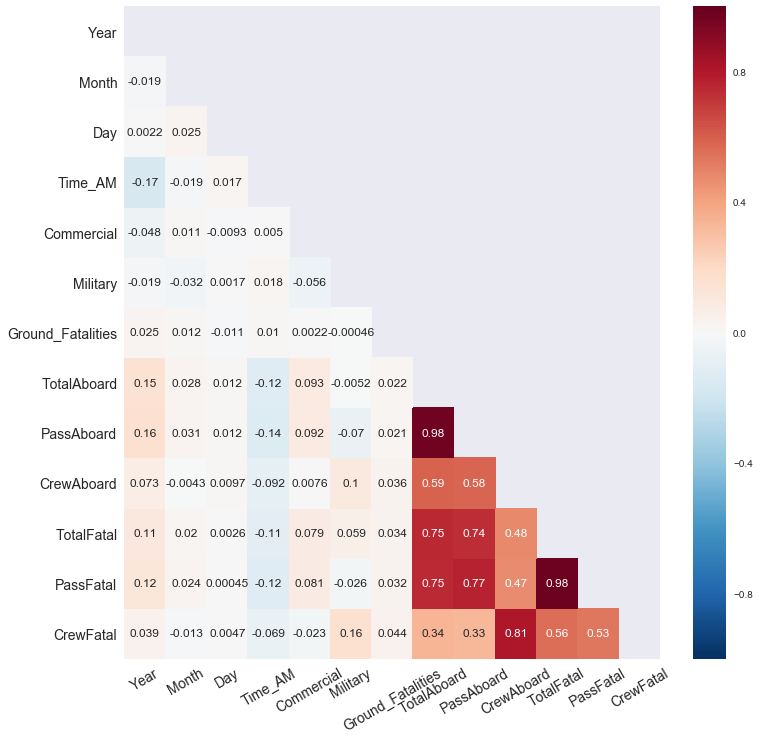

In [48]:
def correlation_heat_map(df):
    corrs = df.corr()
    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12, 12))
    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)
    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

correlation_heat_map(crashes)

# Looking at the heat map below to find correlations. There are not much of insights from theheat map other than the 
# Obvious relation between Passenger fatalities and Total fatalities.

## Summary:

- Examining the data, the first task was to get the missing information or null values out of the way to proceed. The data types were also not completely the right format, which required data munging. Certain countries were not spelt right and required to be fixed.
- Exploratory data analysis is a very important step to know the data. Pandas and Plotting was the main tool for my EDA. I was able to view distributions of the features and relations between features.
- Main takeaway from the EDA
    - 1972 was the worst year for the aviation industry
    - Aeroflot seems to be the airline trending for all the wrong reasons!
    - I was able to see trends over the years and gave a good insight about my data
    - It would be good if i could get more features. My potential datasets could be useful for my further analysis

#### Insights Using google maps api to get the Latitude and Longitude information for the Location information
- Below code will be run once to save the data into csv file for location.
- It is an iterative process since at 1st run, google api returns a maximum of only 2500 calls in 24 hours.
- Plus, out of the 2500 calls, there may be around 10-20% of Api timeout error.
- The list is a growing list.

Aim of this part: The plan is to use this Latitude and Longitude information to plot on the map.